# Modélisation des crises économiques

In [35]:
# Data Processing and Visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter
from tools import *  # Ensure that functions like plot_time_series, impute_nan_values_time_series, align_date_ranges are defined here
from scipy.signal import find_peaks

# PCA
from sklearn.decomposition import PCA

# Modeling and Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    roc_auc_score, recall_score, balanced_accuracy_score, roc_curve, auc,
    precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)

from tools import *

## Import Data

In [12]:
cycles_processed = pd.read_csv('./data/cycles_processed.csv')
determinants_processed = pd.read_csv('./data/determinants_processed.csv')

In [13]:
determinants_processed.head()

,year,country,ka_open,cblackmarketexchangerates,acreditmarketregulation,BankAssets_CBShare,FD,Portfolioequityassets,Currentaccountbalance,Capitalaccount,cbie_index,GDPconstant2015US
0,1980,Argentina,0.417237,9.80,4.446113,88.77,0.228351,50.0,-4774.0,0.0,0.5175,2.878000e+11
1,1981,Argentina,0.417237,8.24,4.397397,85.50,0.230102,52.0,-4712.0,0.0,0.5175,2.729000e+11
2,1982,Argentina,0.162948,6.68,4.348682,86.43,0.267035,59.0,-2353.0,0.0,0.5175,2.709000e+11
3,1983,Argentina,0.162948,5.12,4.299967,68.78,0.217450,75.0,-2436.0,0.0,0.5175,2.827000e+11
4,1984,Argentina,0.162948,3.56,4.251251,74.45,0.230107,78.0,-2495.0,0.0,0.5175,2.871000e+11


In [14]:
determinants_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1831 entries, 0 to 1830
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       1831 non-null   int64  
 1   country                    1831 non-null   object 
 2   ka_open                    1831 non-null   float64
 3   cblackmarketexchangerates  1831 non-null   float64
 4   acreditmarketregulation    1831 non-null   float64
 5   BankAssets_CBShare         1831 non-null   float64
 6   FD                         1831 non-null   float64
 7   Portfolioequityassets      1831 non-null   float64
 8   Currentaccountbalance      1831 non-null   float64
 9   Capitalaccount             1831 non-null   float64
 10  cbie_index                 1831 non-null   float64
 11  GDPconstant2015US          1831 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 171.8+ KB


In [15]:
cycles_processed.head()

,year,country,rpp_value,cgdp_value,cr_value,spr_value,rpp_value_trend,rpp_value_cycle,rpp_value_cycle_normalized,cgdp_value_trend,...,cgdp_value_cycle_normalized,cr_value_trend,cr_value_cycle,cr_value_cycle_normalized,spr_value_trend,spr_value_cycle,spr_value_cycle_normalized,pca_weighted_mean,turning_point,value
0,1970,Australia,32.4367,62.4,9.763825,66.374039,17.341553,15.095147,1.000000,56.486108,...,1.000000,-10.215356,19.979181,1.000000,34.124205,32.249834,1.000000,1.000000,NaN,0.0
1,1971,Australia,34.1111,61.8,10.055262,61.761449,19.203306,14.907794,0.987589,59.299733,...,0.422779,-7.646934,17.702196,0.886032,35.588990,26.172459,0.811553,0.896601,NaN,0.0
2,1972,Australia,36.7062,62.7,10.501544,73.306428,21.065096,15.641104,1.036168,62.113373,...,0.099195,-5.078462,15.580006,0.779812,37.053855,36.252573,1.124117,0.885048,NaN,0.0
3,1973,Australia,41.0876,67.2,12.216656,52.346214,22.926999,18.160601,1.203075,64.927049,...,0.384341,-2.509845,14.726501,0.737092,38.518947,13.827267,0.428755,1.056407,NaN,0.0
4,1974,Australia,40.1630,72.4,13.607510,30.332724,24.789129,15.373871,1.018465,67.740783,...,0.787843,0.059049,13.548461,0.678129,39.984503,-9.651779,-0.299281,0.961808,NaN,0.0


In [16]:
cycles_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         1207 non-null   int64  
 1   country                      1207 non-null   object 
 2   rpp_value                    1207 non-null   float64
 3   cgdp_value                   1207 non-null   float64
 4   cr_value                     1207 non-null   float64
 5   spr_value                    1207 non-null   float64
 6   rpp_value_trend              1207 non-null   float64
 7   rpp_value_cycle              1207 non-null   float64
 8   rpp_value_cycle_normalized   1207 non-null   float64
 9   cgdp_value_trend             1207 non-null   float64
 10  cgdp_value_cycle             1207 non-null   float64
 11  cgdp_value_cycle_normalized  1207 non-null   float64
 12  cr_value_trend               1207 non-null   float64
 13  cr_value_cycle    

In [17]:
cycles_processed['turning_point'] = cycles_processed['turning_point'].fillna('')

In [18]:
cycles_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         1207 non-null   int64  
 1   country                      1207 non-null   object 
 2   rpp_value                    1207 non-null   float64
 3   cgdp_value                   1207 non-null   float64
 4   cr_value                     1207 non-null   float64
 5   spr_value                    1207 non-null   float64
 6   rpp_value_trend              1207 non-null   float64
 7   rpp_value_cycle              1207 non-null   float64
 8   rpp_value_cycle_normalized   1207 non-null   float64
 9   cgdp_value_trend             1207 non-null   float64
 10  cgdp_value_cycle             1207 non-null   float64
 11  cgdp_value_cycle_normalized  1207 non-null   float64
 12  cr_value_trend               1207 non-null   float64
 13  cr_value_cycle    

In [19]:
# Merge df
df_crises = pd.merge(determinants_processed, cycles_processed[['pca_weighted_mean', 'year', 'country', 'turning_point', 'value']], on=['year', 'country'], how='inner')
df_crises.head()

,year,country,ka_open,cblackmarketexchangerates,acreditmarketregulation,BankAssets_CBShare,FD,Portfolioequityassets,Currentaccountbalance,Capitalaccount,cbie_index,GDPconstant2015US,pca_weighted_mean,turning_point,value
0,1980,Australia,0.417237,9.80,8.379046,88.67,0.282372,260.00000,-4447.4908,-140.98176,0.391,4.513000e+11,0.017423,,0.000000
1,1981,Australia,0.417237,9.84,8.436436,88.18,0.291066,246.47632,-8580.7468,-158.88845,0.391,4.664000e+11,-0.051863,,0.000000
2,1982,Australia,0.417237,9.88,8.493827,94.03,0.282234,568.27662,-8511.9286,-178.80629,0.391,4.819000e+11,-0.354190,,0.000000
3,1983,Australia,0.417237,9.92,8.551218,95.09,0.319150,953.64589,-6330.4286,-171.65049,0.391,4.712000e+11,-0.404077,,0.000000
4,1984,Australia,0.477069,9.96,8.608609,93.66,0.354872,1245.10990,-8859.5669,-183.43452,0.391,4.928000e+11,-0.413856,trough,-0.413856


In [20]:
df_crises.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       858 non-null    int64  
 1   country                    858 non-null    object 
 2   ka_open                    858 non-null    float64
 3   cblackmarketexchangerates  858 non-null    float64
 4   acreditmarketregulation    858 non-null    float64
 5   BankAssets_CBShare         858 non-null    float64
 6   FD                         858 non-null    float64
 7   Portfolioequityassets      858 non-null    float64
 8   Currentaccountbalance      858 non-null    float64
 9   Capitalaccount             858 non-null    float64
 10  cbie_index                 858 non-null    float64
 11  GDPconstant2015US          858 non-null    float64
 12  pca_weighted_mean          858 non-null    float64
 13  turning_point              858 non-null    object 

## Model

In [30]:
def train_test_with_cv(
    model,
    param_grid,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name="Model",
    scoring="roc_auc",  # or "balanced_accuracy"
    cv=5,
    n_jobs=-1,
    verbose=1,
    plot_roc=True,
    threshold=None  # New parameter for custom threshold
):
    # Initialize GridSearchCV
    search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        refit=True  # Best params re-fitted automatically
    )

    # Fit on the entire training set (CV happens internally)
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    print(f"Best params ({model_name}): {search.best_params_}")
    print(f"Best CV {scoring} Score: {search.best_score_:.3f}\n")
    print("Class ordering:", best_model.classes_)
    
    # Determine if model uses decision_function or predict_proba
    if hasattr(best_model, "predict_proba"):
        pos_index = list(best_model.classes_).index(1)
        y_train_proba = best_model.predict_proba(X_train)[:, pos_index]
        y_test_proba = best_model.predict_proba(X_test)[:, pos_index]
    elif hasattr(best_model, "decision_function"):
        # Use decision function for thresholding
        decision_train = best_model.decision_function(X_train)
        y_train_proba = (decision_train - decision_train.min()) / (decision_train.max() - decision_train.min())
        
        decision_test = best_model.decision_function(X_test)
        y_test_proba = (decision_test - decision_test.min()) / (decision_test.max() - decision_test.min())
    else:
        raise AttributeError("Model does not have predict_proba or decision_function methods.")
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_auc = roc_auc_score(y_train, y_train_proba)
    train_bal_acc = balanced_accuracy_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    
    test_auc = roc_auc_score(y_test, y_test_proba)
    test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    
    # Print metrics
    print(f"{model_name} Train AUC: {train_auc:.3f}")
    print(f"{model_name} Train Balanced Acc: {train_bal_acc:.3f}")
    print(f"{model_name} Train Recall: {train_recall:.3f}")
    print(f"{model_name} Test AUC: {test_auc:.3f}")
    print(f"{model_name} Test Balanced Acc: {test_bal_acc:.3f}")
    print(f"{model_name} Test Recall: {test_recall:.3f}\n")
    
    # Plot ROC curves
    if plot_roc:
        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    
        plt.figure(figsize=(8,6))
        plt.plot(fpr_train, tpr_train, label=f"Train (AUC={auc(fpr_train, tpr_train):.3f})")
        plt.plot(fpr_test, tpr_test, label=f"Test (AUC={auc(fpr_test, tpr_test):.3f})")
        plt.plot([0,1],[0,1], "--", color="gray")
        plt.title(f"{model_name} ROC curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend(loc="lower right")
        plt.show()
    
    # Handle custom threshold if provided
    if threshold is not None:
        # For SVM without predict_proba, use decision function
        if hasattr(best_model, "decision_function"):
            y_test_custom = (best_model.decision_function(X_test) > 0).astype(int)
        else:
            y_test_custom = (y_test_proba > threshold).astype(int)
        
        # Calculate metrics based on custom threshold
        recall_custom = recall_score(y_test, y_test_custom)
        precision_custom = precision_score(y_test, y_test_custom)
        f1_custom = f1_score(y_test, y_test_custom)
        roc_auc_custom = roc_auc_score(y_test, y_test_proba)  # AUC remains based on probabilities
    
        print(f"Metrics with Custom Threshold ({threshold}):")
        print(f"Recall: {recall_custom:.3f}")
        print(f"Precision: {precision_custom:.3f}")
        print(f"F1 Score: {f1_custom:.3f}")
        print(f"ROC AUC: {roc_auc_custom:.3f}\n")
    
        # Optional: Plot confusion matrix or other relevant plots
        cm = confusion_matrix(y_test, y_test_custom)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"{model_name} Confusion Matrix at Threshold {threshold}")
        plt.show()
    
        if hasattr(best_model, "decision_function"):
            # For SVM, compare custom threshold with default predict
            y_test_custom_compare = (best_model.decision_function(X_test) > 0).astype(int)
            print("Default Predictions:", y_test_pred[:10])
            print("Custom Threshold Predictions:", y_test_custom_compare[:10])
            print("Are they identical?", np.array_equal(y_test_pred, y_test_custom_compare))
        else:
            print("Default and Custom threshold predictions may differ based on threshold logic.")
    
    return best_model


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params (Logistic Regression (scaled)): {'logreg__C': 1, 'logreg__penalty': 'l1'}
Best CV roc_auc Score: 0.991

Class ordering: [0 1]
Logistic Regression (scaled) Train AUC: 0.995
Logistic Regression (scaled) Train Balanced Acc: 0.961
Logistic Regression (scaled) Train Recall: 0.929
Logistic Regression (scaled) Test AUC: 0.944
Logistic Regression (scaled) Test Balanced Acc: 0.955
Logistic Regression (scaled) Test Recall: 0.909



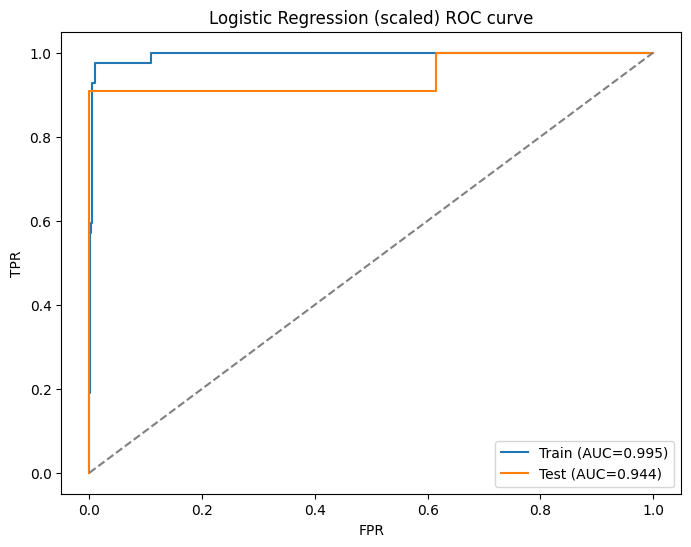

Metrics with Custom Threshold (0.5):
Recall: 0.909
Precision: 1.000
F1 Score: 0.952
ROC AUC: 0.944



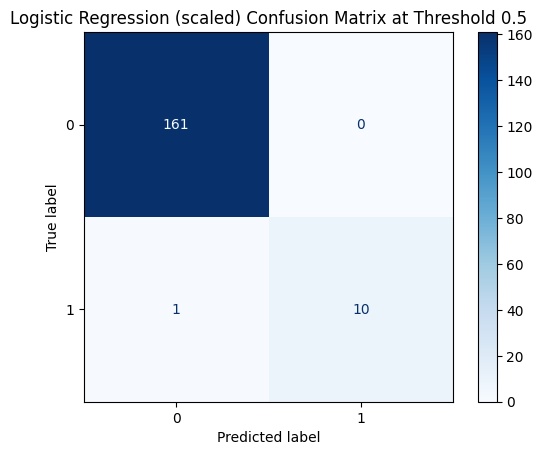

Default Predictions: [0 0 0 0 0 0 0 0 0 0]
Custom Threshold Predictions: [0 0 0 0 0 0 0 0 0 0]
Are they identical? True


In [40]:
pipe_log = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42))
])

param_grid_log = {
    "logreg__C": [0.001, 0.01, 0.1, 1, 10],
    "logreg__penalty": ["l2", "l1"],
}

best_log = train_test_with_cv(
    model=pipe_log,
    param_grid=param_grid_log,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Logistic Regression (scaled)",
    scoring="roc_auc",
    threshold=0.5
    
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params (Random Forest): {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 140}
Best CV recall Score: 0.928

Class ordering: [0 1]
Random Forest Train AUC: 1.000
Random Forest Train Balanced Acc: 0.998
Random Forest Train Recall: 1.000
Random Forest Test AUC: 0.968
Random Forest Test Balanced Acc: 0.818
Random Forest Test Recall: 0.636



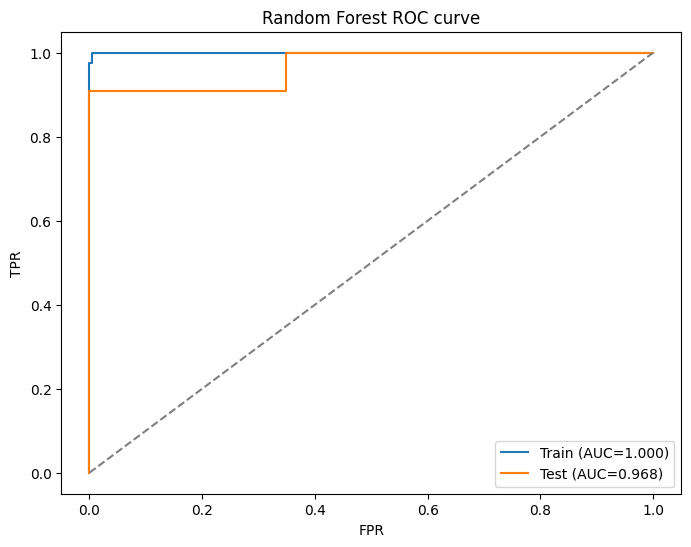

Metrics with Custom Threshold (0.4):
Recall: 0.818
Precision: 1.000
F1 Score: 0.900
ROC AUC: 0.968



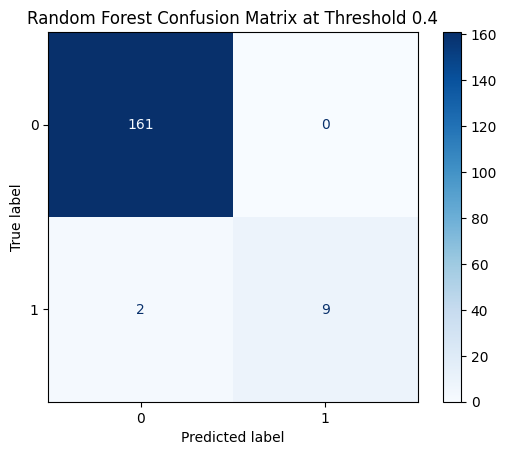

Default and Custom threshold predictions may differ based on threshold logic.


In [42]:
# Définir le modèle
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Définir la grille d'hyperparamètres
param_grid_rf = {
    'n_estimators': [140],  # Nombre d'arbres
    'max_depth': [10],       # Profondeur maximale
    'min_samples_split': [10], # Min. échantillons pour division
    'min_samples_leaf': [4],   # Min. échantillons dans une feuille
    'bootstrap': [False]       # Échantillonnage bootstrap
}

# Appeler la fonction
best_rf = train_test_with_cv(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model=rf_clf,
    param_grid=param_grid_rf,
    model_name="Random Forest",
    scoring='recall',
    threshold=0.4
)


